In [1]:
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name() # Check GPU

2.8.0


'/device:GPU:0'

**Import Dataset from gdrive**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Dataset  gdrive  sample_data


**Import Libraries**

In [3]:
# Libraries for do visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for do computational things
import numpy as np
import pandas as pd


import datetime
import os

# For evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

# from tensorflow.keras.applications.mobilenetv2
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.backend import clear_session
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, TensorBoard, EarlyStopping

**Extract Datset**

In [4]:
from tqdm import tqdm
import zipfile

with zipfile.ZipFile('/content/gdrive/MyDrive/Dataset/Cats-and-Dogs-Breed-Clasification.zip','r') as zf:
    for member in tqdm(zf.infolist(), desc='Extracting '):
        try:
            zf.extract(member, '/content/Dataset')
        except zipfile.error as e:
            pass

Extracting : 100%|██████████| 2025/2025 [00:01<00:00, 1396.29it/s]


**Check inside Datast**

In [5]:
DATASET_PATH = '/content/Dataset/Cats and Dogs Breed Clasification'

os.listdir(DATASET_PATH)

['train', 'test']

In [6]:
class_names = sorted(os.listdir('/content/Dataset/Cats and Dogs Breed Clasification/train'))
print(class_names)

['Abyssinian', 'Beagle', 'Bombay', 'British Shorthair', 'Chihuahua', 'Persian', 'Pomeranian', 'Pug', 'Shiba Inu', 'Siamese']


In [7]:
def list_dir(class_names, slice='train'):
  return os.listdir('/content/Dataset/Cats and Dogs Breed Clasification/{}/{}'.format(slice, class_names))

for i in class_names:
  print(i)
  print(len(list_dir(i, 'train')))
  print(len(list_dir(i, 'test')))

Abyssinian
153
50
Beagle
150
50
Bombay
150
50
British Shorthair
150
50
Chihuahua
150
50
Persian
150
50
Pomeranian
150
50
Pug
150
50
Shiba Inu
150
50
Siamese
150
50


**Image Preprocessing**

In [8]:
train_path = '/content/Dataset/Cats and Dogs Breed Clasification/train'
test_path = '/content/Dataset/Cats and Dogs Breed Clasification/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, 
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    shear_range=0.2, 
    horizontal_flip=True, 
    zoom_range=0.2
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    color_mode='rgb'
)

val_set = validation_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    color_mode='rgb'
)

breed_dict = train_set.class_indices
print(breed_dict)

Found 1500 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
{'Abyssinian': 0, 'Beagle': 1, 'Bombay': 2, 'British Shorthair': 3, 'Chihuahua': 4, 'Persian': 5, 'Pomeranian': 6, 'Pug': 7, 'Shiba Inu': 8, 'Siamese': 9}


In [9]:
# Create variabel X_train and y_train
X_train, y_train = train_set.next()

# Create variabel X_val and y_val
X_val, y_val = val_set.next()

In [10]:
X_train.shape

(32, 224, 224, 3)

In [11]:
class_dict = {v : k for k, v in train_set.class_indices.items()}

def plotimgs(X, y):
  labels=[]
  y_label = np.argmax(y, axis=1)
  
  for label in y_label:
    labels.append(class_dict[label])

  for idx in range(0,10):
      plt.figure(figsize=(5, 5))
      plt.imshow(X[idx])
      plt.title(labels[idx])

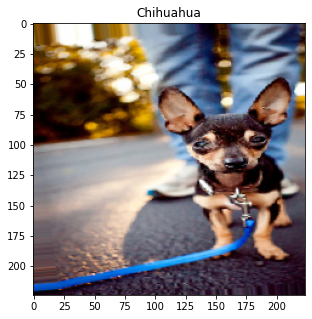

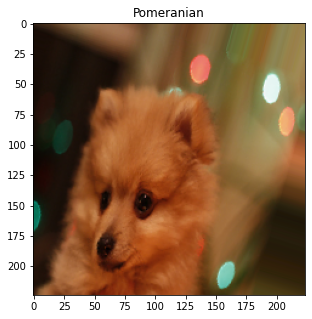

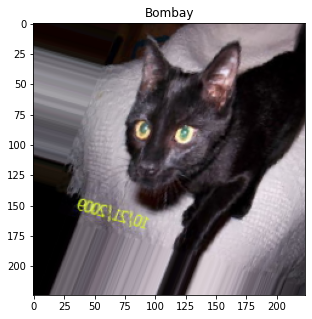

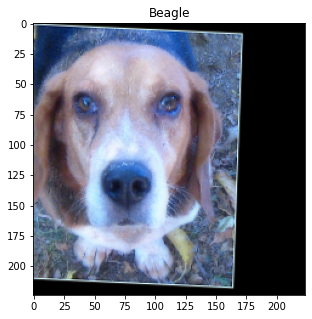

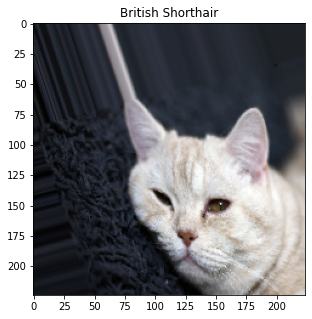

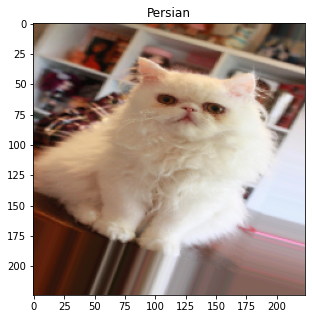

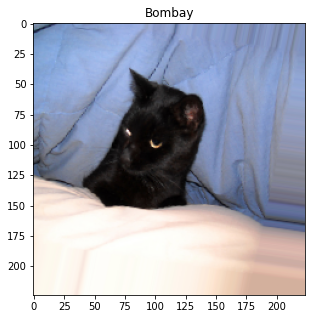

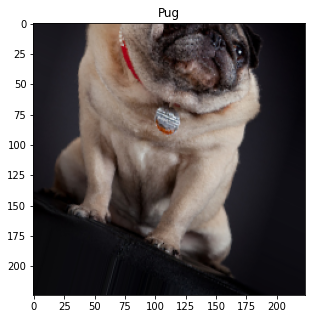

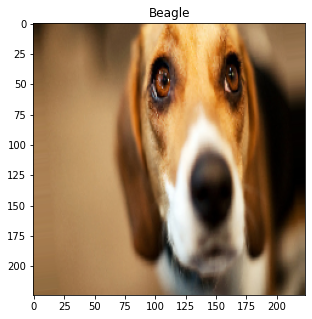

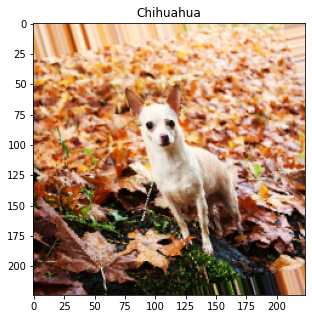

In [12]:
plotimgs(X_train, y_train)

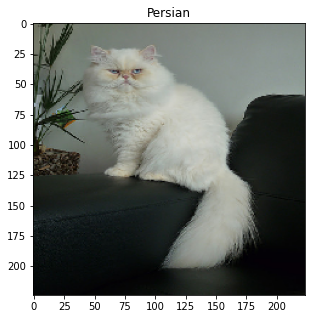

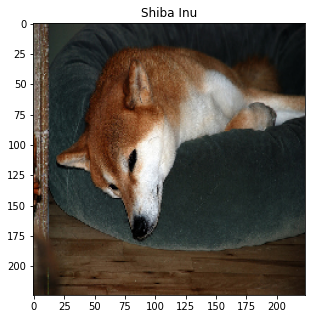

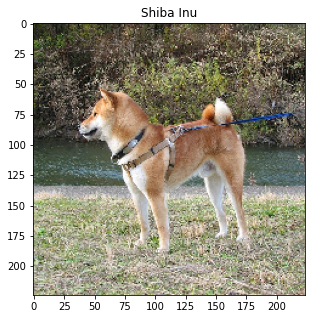

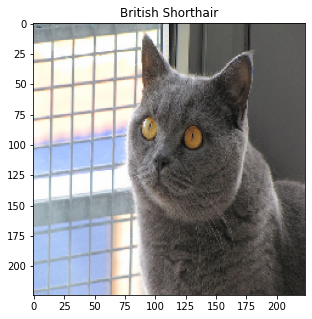

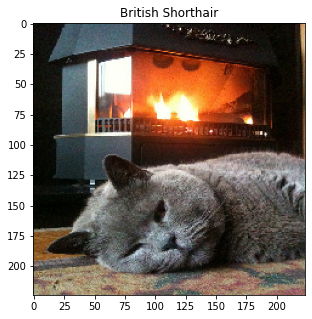

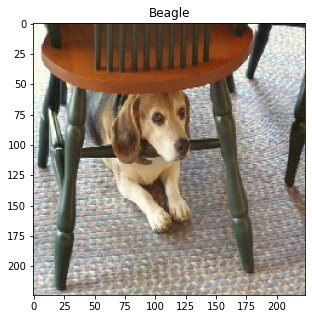

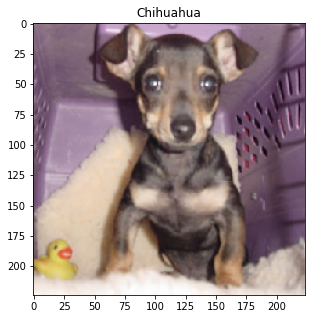

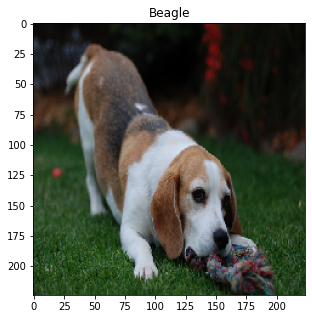

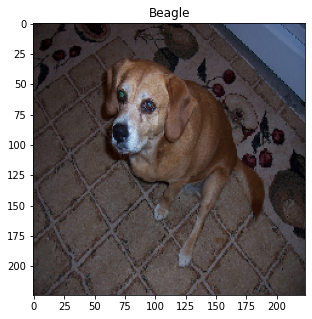

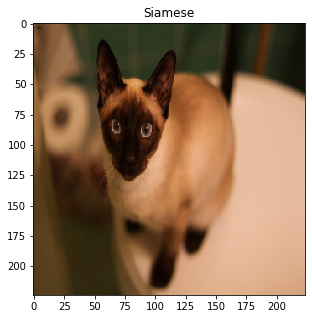

In [13]:
plotimgs(X_val, y_val)

**Evaluate models**

In [14]:
val_set.class_indices

{'Abyssinian': 0,
 'Beagle': 1,
 'Bombay': 2,
 'British Shorthair': 3,
 'Chihuahua': 4,
 'Persian': 5,
 'Pomeranian': 6,
 'Pug': 7,
 'Shiba Inu': 8,
 'Siamese': 9}

In [15]:
def evaluate_model(model, X, y):
  print('Loss of the model is - ', model.evaluate(X, y)[0])
  print('Accuracy of the model is - ', model.evaluate(X, y)[1]*100, '%')
  predict = model.predict(X)
  # print(predict)
  predict = np.argmax(predict, axis=1)
  predict = predict.reshape(1, -1)[0]
  y_label = np.argmax(y, axis=1)
  print(classification_report(y_label, predict, target_names =['Abyssinian','Beagle', 'Bombay','British Shorthair','Chihuahua','Persian', 'Pomeranian','Pug', 'Shiba Inu','Siamese']))

  conf_matrix = confusion_matrix(y_label, predict)
  # print(conf_matrix)
  df_cm = pd.DataFrame(conf_matrix, index = [i for i in ('Abyssinian','Beagle', 'Bombay','British Shorthair','Chihuahua','Persian', 'Pomeranian','Pug', 'Shiba Inu','Siamese')],
                  columns = [i for i in ('Abyssinian','Beagle', 'Bombay','British Shorthair','Chihuahua','Persian', 'Pomeranian','Pug', 'Shiba Inu','Siamese')])
  plt.figure(figsize = (3, 3))
  sns.heatmap(df_cm, annot=True)

plt.style.use('seaborn-whitegrid')

def plot_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.subplot(1, 2, 1)
  acc_plot, = plt.plot(epochs, acc, 'green')
  val_acc_plot, = plt.plot(epochs, val_acc, 'blue')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])


def plot_loss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.subplot(1, 2, 2)
  loss_plot, = plt.plot(epochs, loss, 'green')
  val_loss_plot, = plt.plot(epochs, val_loss, 'blue')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

def plot_hist(history):
  plt.figure(figsize=(15,5))
  plot_acc(history)
  plot_loss(history)

# **Model Building**

Using Transfer Learning to reduce training time, and improve accuracy

In [16]:
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    alpha=1.0
)

base_model.trainable = False

In [20]:
LEARNING_RATE = 1e-4
clear_session()

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu',
          kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
    ),
    Dropout(0.25),
    Dense(10, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2

In [22]:
def scheduler(epoch, lr):
  if epoch <= 15:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

callbacks =[lr_cb]

In [23]:
# Trains for 25 epochs
history = model.fit(train_set,
                    epochs=25,
                    validation_data = val_set,
                    verbose = 1,
                    shuffle=True,
                    callbacks=callbacks
)

Epoch 1/25
47/47 [==============================] - 32s 548ms/step - loss: 1.5572 - accuracy: 0.5873 - val_loss: 0.7692 - val_accuracy: 0.8860 - lr: 1.0000e-04
Epoch 2/25
47/47 [==============================] - 24s 515ms/step - loss: 0.5579 - accuracy: 0.8967 - val_loss: 0.4346 - val_accuracy: 0.9180 - lr: 1.0000e-04
Epoch 3/25
47/47 [==============================] - 24s 504ms/step - loss: 0.3633 - accuracy: 0.9240 - val_loss: 0.3815 - val_accuracy: 0.9180 - lr: 1.0000e-04
Epoch 4/25
47/47 [==============================] - 24s 512ms/step - loss: 0.3004 - accuracy: 0.9380 - val_loss: 0.3344 - val_accuracy: 0.9280 - lr: 1.0000e-04
Epoch 5/25
47/47 [==============================] - 23s 481ms/step - loss: 0.2403 - accuracy: 0.9573 - val_loss: 0.3102 - val_accuracy: 0.9420 - lr: 1.0000e-04
Epoch 6/25
47/47 [==============================] - 24s 502ms/step - loss: 0.2290 - accuracy: 0.9560 - val_loss: 0.2979 - val_accuracy: 0.9420 - lr: 1.0000e-04
Epoch 7/25
47/47 [======================

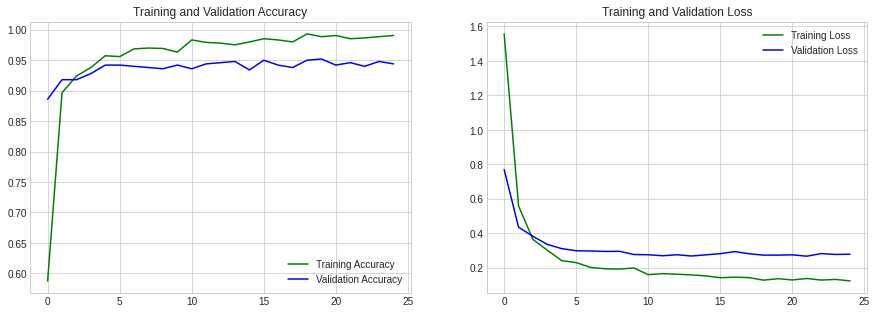

In [24]:
plot_hist(history)

1/1 [==============================] - 1s 778ms/step - loss: 0.1032 - accuracy: 1.0000
Loss of the model is -  0.10322119295597076
1/1 [==============================] - 0s 73ms/step - loss: 0.1032 - accuracy: 1.0000
Accuracy of the model is -  100.0 %
                   precision    recall  f1-score   support

       Abyssinian       1.00      1.00      1.00         1
           Beagle       1.00      1.00      1.00         3
           Bombay       1.00      1.00      1.00         2
British Shorthair       1.00      1.00      1.00         5
        Chihuahua       1.00      1.00      1.00         3
          Persian       1.00      1.00      1.00         3
       Pomeranian       1.00      1.00      1.00         3
              Pug       1.00      1.00      1.00         2
        Shiba Inu       1.00      1.00      1.00         5
          Siamese       1.00      1.00      1.00         5

         accuracy                           1.00        32
        macro avg       1.00      1.0

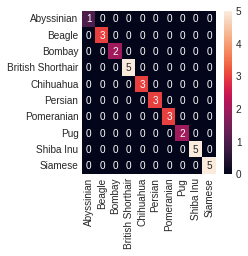

In [25]:
evaluate_model(model, X_val, y_val)

In [26]:
test_dir = '/content/Dataset/Cats and Dogs Breed Clasification/test'

for breed in breed_dict.keys():
    images_list = os.listdir(os.path.join(test_dir, breed))    
    # plt.figure(figsize=(16, 20))

    correct_count = 0

    for idx, image in enumerate(images_list):
        img_path = f'/content/Dataset/Cats and Dogs Breed Clasification/test/{breed}/{image}'
        img = load_img(img_path, target_size=(224, 224))

        img_array = img_to_array(img) / 255.0
        img_array = tf.expand_dims(img_array, 0)

        breed_list = list(breed_dict.keys())
        prediction = model(img_array)
        pred_idx = np.argmax(prediction)
        pred_breed = breed_list[pred_idx]
        pred_confidence = prediction[0][pred_idx] * 100

        if pred_breed == breed:
            correct_count += 1
    
    print(f'{breed} Predictions --> {correct_count}/50 correct')


Abyssinian Predictions --> 47/50 correct
Beagle Predictions --> 46/50 correct
Bombay Predictions --> 49/50 correct
British Shorthair Predictions --> 46/50 correct
Chihuahua Predictions --> 48/50 correct
Persian Predictions --> 47/50 correct
Pomeranian Predictions --> 50/50 correct
Pug Predictions --> 49/50 correct
Shiba Inu Predictions --> 43/50 correct
Siamese Predictions --> 47/50 correct


In [27]:
from keras.preprocessing import image
print(sorted(class_names))

testing = [
         '/content/Dataset/Cats and Dogs Breed Clasification/test/Abyssinian/Abyssinian_166.jpg',
         '/content/gdrive/MyDrive/Dataset/Anjing-Shiba-Inu.jpg',
         '/content/Dataset/Cats and Dogs Breed Clasification/test/British Shorthair/British_Shorthair_182.jpg',
         '/content/gdrive/MyDrive/Dataset/pug.jpg',
         '/content/Dataset/Cats and Dogs Breed Clasification/test/Persian/Persian_185.jpg',
         '/content/gdrive/MyDrive/Dataset/Beagle_600.jpg',
         '/content/Dataset/Cats and Dogs Breed Clasification/test/Beagle/beagle_166.jpg',
         '/content/Dataset/Cats and Dogs Breed Clasification/test/Pomeranian/pomeranian_184.jpg',
         '/content/gdrive/MyDrive/Dataset/kucingbombaytest.jpg',
         ]

predict_result = []
percent = []

for fn in testing:
  path = fn
  img = image.load_img(path, color_mode="rgb", target_size=(224,224), interpolation="nearest")
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x/255.0
  images = np.vstack([x])
  classes = model.predict(images)
  print(fn)
  predict_result.append(np.argmax(classes))
  percent.append(max(classes[0]))

['Abyssinian', 'Beagle', 'Bombay', 'British Shorthair', 'Chihuahua', 'Persian', 'Pomeranian', 'Pug', 'Shiba Inu', 'Siamese']
/content/Dataset/Cats and Dogs Breed Clasification/test/Abyssinian/Abyssinian_166.jpg
/content/gdrive/MyDrive/Dataset/Anjing-Shiba-Inu.jpg
/content/Dataset/Cats and Dogs Breed Clasification/test/British Shorthair/British_Shorthair_182.jpg
/content/gdrive/MyDrive/Dataset/pug.jpg
/content/Dataset/Cats and Dogs Breed Clasification/test/Persian/Persian_185.jpg
/content/gdrive/MyDrive/Dataset/Beagle_600.jpg
/content/Dataset/Cats and Dogs Breed Clasification/test/Beagle/beagle_166.jpg
/content/Dataset/Cats and Dogs Breed Clasification/test/Pomeranian/pomeranian_184.jpg
/content/gdrive/MyDrive/Dataset/kucingbombaytest.jpg


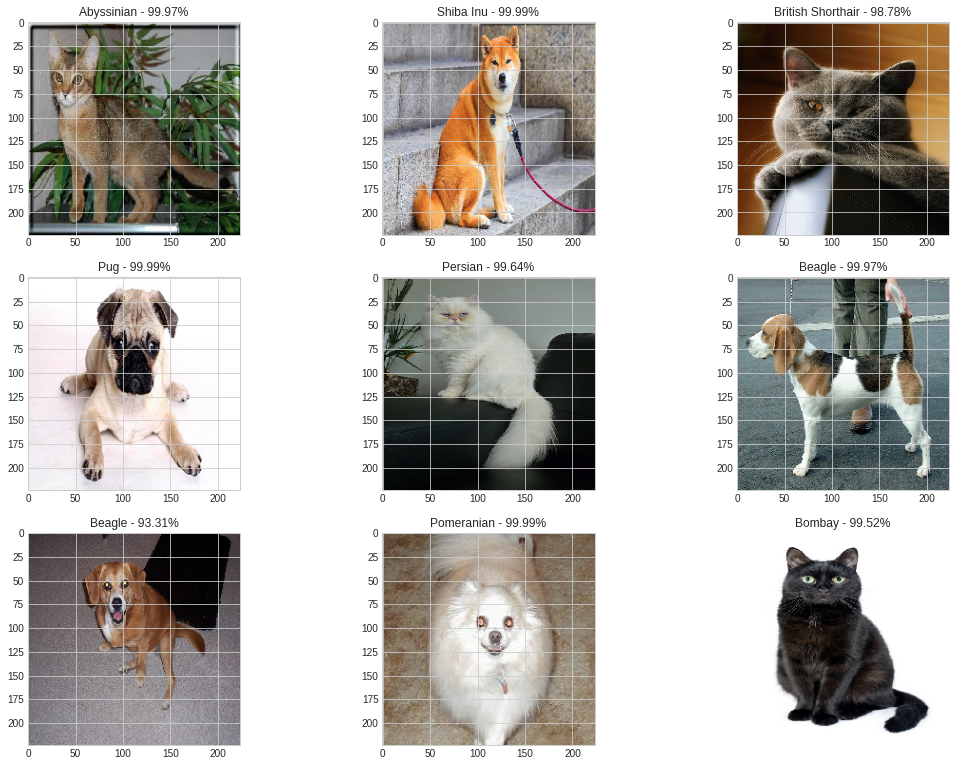

In [28]:
plt.figure(figsize=(18, 18))

num_index = 0
for images in testing:
  plt.subplot((len(testing)/3)+1, 3, num_index+1)
  plt.imshow(image.load_img(images, color_mode="rgb", target_size=(224,224), interpolation="nearest"))
  plt.title("{} - {:0.2f}%".format(class_names[predict_result[num_index]], percent[num_index]*100))
  num_index += 1
plt.axis('off')
plt.show()

In [30]:
from google.colab import files
def save_model_func(model_var, model_name):
  os.chdir('/content')
  try:
    os.mkdir('modelml')
  except:
    pass
  model_var.save('models/{}'.format(model_name))

  converter = tf.lite.TFLiteConverter.from_saved_model('models/{}'.format(model_name))

  lab_datagen = ImageDataGenerator(
    rescale=1./255
  )

  lab_flow = lab_datagen.flow_from_directory(
    test_dir,
    batch_size=1,
    target_size=(224,224),
    shuffle=True,
    class_mode='categorical',
  )

  def representative_data_gen():
    for _ in range(300):
      img_with_label = lab_flow.next() # it returns (image and label) tuple
      yield [np.array(img_with_label[0], dtype=np.float32, ndmin=2)] # return image
    
  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  tflite_model = converter.convert()

  with open('{}.tflite'.format(model_name), 'wb') as f:
    f.write(tflite_model)

  files.download('{}.tflite'.format(model_name))

  with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

  files.download('labels.txt')
  return tflite_model

In [31]:
lite_model = save_model_func(model, 'catdogsclasifier')

INFO:tensorflow:Assets written to: models/catdogsclasifier/assets


INFO:tensorflow:Assets written to: models/catdogsclasifier/assets


Found 500 images belonging to 10 classes.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
model.save('catsdogsclasifierv4.h5')

In [33]:
!zip -r /content/catsdogsclasifier.zip /content/models/catdogsclasifier

  adding: content/models/catdogsclasifier/ (stored 0%)
  adding: content/models/catdogsclasifier/variables/ (stored 0%)
  adding: content/models/catdogsclasifier/variables/variables.index (deflated 76%)
  adding: content/models/catdogsclasifier/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/models/catdogsclasifier/saved_model.pb (deflated 91%)
  adding: content/models/catdogsclasifier/assets/ (stored 0%)
  adding: content/models/catdogsclasifier/keras_metadata.pb (deflated 96%)


In [34]:
model = tf.keras.models.load_model('/content/models/catdogsclasifier')
lite_model = tf.lite.Interpreter(model_path='/content/catdogsclasifier.tflite')

In [38]:
# interpreter = tf.lite.Interpreter(model_content=lite_model)
interpreter = lite_model

interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

predictions = []

lab_datagen = ImageDataGenerator(
   rescale=1./255
)

lab_flow = lab_datagen.flow_from_directory(
    test_dir,
    batch_size=1,
    target_size=(224,224),
    shuffle=True,
    class_mode='categorical',
)
test_labels, test_imgs = [], []
for _ in range(10):
  image_file = list(lab_flow.next())
  test_imgs.append(image_file[0])
  print(image_file[1])
  test_labels.append(np.argmax(image_file[1]))

  if input_details['dtype'] == np.uint8:
    input_scale, input_zero_point = input_details['quantization']
    image_file[0] = image_file[0] / input_scale + input_zero_point
  
  image_file[0] = image_file[0].astype(input_details['dtype'])
  interpreter.set_tensor(input_details['index'], image_file[0])
  interpreter.invoke()
  output = interpreter.get_tensor(output_details['index'])[0]
  predictions.append(output)

Found 500 images belonging to 10 classes.
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [39]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    print(type(predicted_label), type(true_label))
        
    plt.xlabel("{} {:0.2f}% ({})".format(class_names[predicted_label],
                                         np.max(predictions_array)*100,
                                         class_names[true_label]))

<class 'numpy.int64'> <class 'numpy.int64'>


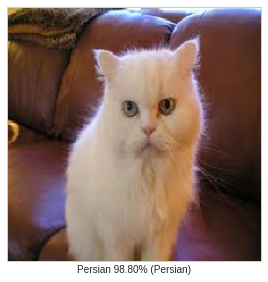

In [45]:
#@title Visualize the outputs { run: "auto" }
index = 8 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()